In [26]:
import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import tensorflow as tf
tf.get_logger().setLevel("ERROR")


# Charger le CSV
df = pd.read_csv("../data/dataset_selection_non_zoomer.csv")

# Aperçu du dataset
print("Aperçu du dataset :")
print(df.head())

print("\nInformations générales :")
print(df.info())


Aperçu du dataset :
                                                path     label
0  E:\mémoire\Memoire\data\glaucome\DRISHTI-GS\DR...  glaucome
1  E:\mémoire\Memoire\data\glaucome\DRISHTI-GS\DR...  glaucome
2  E:\mémoire\Memoire\data\glaucome\DRISHTI-GS\DR...  glaucome
3  E:\mémoire\Memoire\data\glaucome\DRISHTI-GS\DR...  glaucome
4  E:\mémoire\Memoire\data\glaucome\DRISHTI-GS\DR...  glaucome

Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7988 entries, 0 to 7987
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    7988 non-null   object
 1   label   7988 non-null   object
dtypes: object(2)
memory usage: 124.9+ KB
None


In [27]:
print(f"Nombre total d'images : {len(df)}")
print(f"Nombre de colonnes : {df.shape[1]}")


Nombre total d'images : 7988
Nombre de colonnes : 2


In [28]:
# Compter le nombre d'images par label
class_counts = df['label'].value_counts()

print("\nRépartition des labels :")
print(class_counts)

# Pourcentage par label
class_percent = df['label'].value_counts(normalize=True) * 100
print("\nPourcentage par label :")
print(class_percent.round(2))



Répartition des labels :
label
mda         2046
diabete     2000
normaux     1993
glaucome    1949
Name: count, dtype: int64

Pourcentage par label :
label
mda         25.61
diabete     25.04
normaux     24.95
glaucome    24.40
Name: proportion, dtype: float64


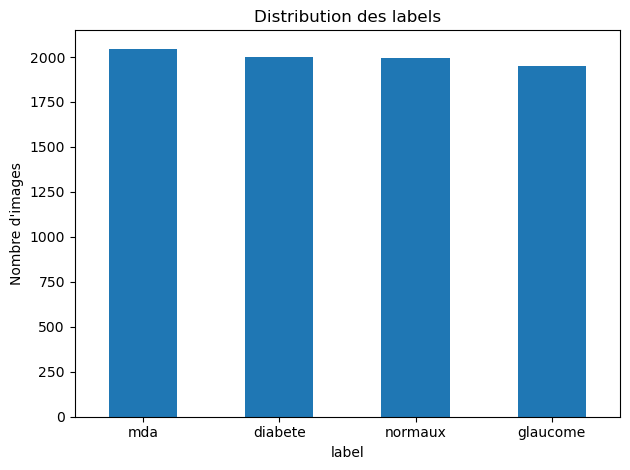

In [29]:
import matplotlib.pyplot as plt

class_counts.plot(kind='bar')
plt.title("Distribution des labels")
plt.xlabel("label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [30]:
for classe in df['label'].unique():
    print(f"\nExemples pour la classe '{classe}' :")
    print(df[df['label'] == classe]['path'].head(3).tolist())



Exemples pour la classe 'glaucome' :
['E:\\mémoire\\Memoire\\data\\glaucome\\DRISHTI-GS\\DRISHTI-GS\\Training\\glaucoma\\drishtiGS_002.png', 'E:\\mémoire\\Memoire\\data\\glaucome\\DRISHTI-GS\\DRISHTI-GS\\Training\\glaucoma\\drishtiGS_004.png', 'E:\\mémoire\\Memoire\\data\\glaucome\\DRISHTI-GS\\DRISHTI-GS\\Training\\glaucoma\\drishtiGS_010.png']

Exemples pour la classe 'mda' :
['E:\\mémoire\\Memoire\\data\\mda\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Dataset\\train\\amd\\1012.jpg', 'E:\\mémoire\\Memoire\\data\\mda\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Dataset\\train\\amd\\1013.jpg', 'E:\\mémoire\\Memoire\\data\\mda\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\

In [31]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],
    random_state=42
)

df_test, df_val = train_test_split(
    df_test,
    test_size=0.5,
    stratify=df_test['label'],
    random_state=42
)




print("Tailles des splits :")
print(f"Train : {len(df_train)}")
print(f"Test : {len(df_test)}")
print(f"Validation : {len(df_val)}")

Tailles des splits :
Train : 5591
Test : 1198
Validation : 1199


In [32]:
def show_distribution(name, data):
    print(f"\n{name}")
    print(data['label'].value_counts(normalize=True).round(3))

show_distribution("Train", df_train)
show_distribution("Test", df_test)
show_distribution("Validation", df_val)



Train
label
mda         0.256
diabete     0.250
normaux     0.250
glaucome    0.244
Name: proportion, dtype: float64

Test
label
mda         0.256
diabete     0.250
normaux     0.250
glaucome    0.244
Name: proportion, dtype: float64

Validation
label
mda         0.256
diabete     0.250
normaux     0.249
glaucome    0.244
Name: proportion, dtype: float64


In [33]:
import numpy as np

IMG_SIZE = (256, 256)
BATCH_SIZE = 32
SEED = 42

# mapping label -> id (si label est texte)
classes = sorted(df_train["label"].unique().tolist())
label_to_id = {c:i for i,c in enumerate(classes)}

def df_to_ds(df, shuffle=False):
    paths = df["path"].astype(str).values
    labels = df["label"].map(label_to_id).astype(int).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(df), seed=SEED, reshuffle_each_iteration=True)

    def load_and_preprocess(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
        img.set_shape([None, None, 3])
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32)
        return img, label

    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # ✅ ignore les fichiers qui cassent decode_image
    ds = ds.apply(tf.data.experimental.ignore_errors())

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = df_to_ds(df_train, shuffle=True)
val_ds   = df_to_ds(df_val, shuffle=False)
test_ds  = df_to_ds(df_test, shuffle=False)


In [34]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="aug")

#cnn
model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(df['label'].unique()), activation='softmax')
])


early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)





Epoch 1/50
175/175 [==============================] - 72s 377ms/step - loss: 1.0353 - accuracy: 0.5806 - val_loss: 0.7198 - val_accuracy: 0.6976
Epoch 2/50
175/175 [==============================] - 68s 387ms/step - loss: 0.7260 - accuracy: 0.6870 - val_loss: 0.6497 - val_accuracy: 0.7009
Epoch 3/50
175/175 [==============================] - 72s 410ms/step - loss: 0.6887 - accuracy: 0.6938 - val_loss: 0.6152 - val_accuracy: 0.7352
Epoch 4/50
175/175 [==============================] - 68s 386ms/step - loss: 0.6338 - accuracy: 0.7148 - val_loss: 0.6461 - val_accuracy: 0.7335
Epoch 5/50
175/175 [==============================] - 77s 440ms/step - loss: 0.6366 - accuracy: 0.7162 - val_loss: 0.6541 - val_accuracy: 0.6934
Epoch 6/50
175/175 [==============================] - 79s 450ms/step - loss: 0.6329 - accuracy: 0.7213 - val_loss: 0.6160 - val_accuracy: 0.7260
Epoch 7/50
175/175 [==============================] - 75s 429ms/step - loss: 0.6063 - accuracy: 0.7317 - val_loss: 0.6797 - val_ac


=== Scores globaux ===
Accuracy            : 0.7628
Balanced accuracy   : 0.7637
Precision (macro)   : 0.7616
Recall (macro)      : 0.7637
F1 (macro)          : 0.7381
Precision (weighted): 0.7613
Recall (weighted)   : 0.7628
F1 (weighted)       : 0.7374

=== Rapport par classe ===
              precision    recall  f1-score   support

     diabete       0.66      0.96      0.78       300
    glaucome       0.85      0.97      0.90       292
         mda       0.86      0.81      0.84       302
     normaux       0.68      0.31      0.43       299

    accuracy                           0.76      1193
   macro avg       0.76      0.76      0.74      1193
weighted avg       0.76      0.76      0.74      1193



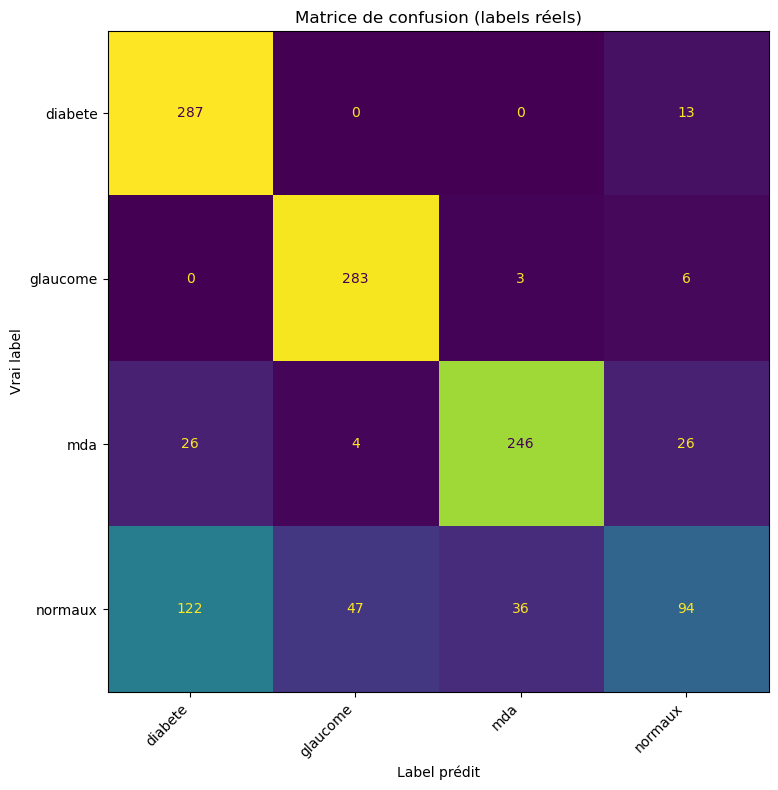

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    classification_report
)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

proba = model.predict(test_ds, verbose=0)
y_pred = np.argmax(proba, axis=1)
num_classes = len(classes)

# ----------------------------
# 7) METRICS
# ----------------------------
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
rec_macro  = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_macro   = f1_score(y_true, y_pred, average="macro", zero_division=0)

prec_weighted = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec_weighted  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1_weighted   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

print("\n=== Scores globaux ===")
print(f"Accuracy            : {acc:.4f}")
print(f"Balanced accuracy   : {bacc:.4f}")
print(f"Precision (macro)   : {prec_macro:.4f}")
print(f"Recall (macro)      : {rec_macro:.4f}")
print(f"F1 (macro)          : {f1_macro:.4f}")
print(f"Precision (weighted): {prec_weighted:.4f}")
print(f"Recall (weighted)   : {rec_weighted:.4f}")
print(f"F1 (weighted)       : {f1_weighted:.4f}")

print("\n=== Rapport par classe ===")
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

# ----------------------------
# 8) CONFUSION MATRIX (labels réels, ordre forcé)
# ----------------------------
label_indices = list(range(num_classes))
cm = confusion_matrix(y_true, y_pred, labels=label_indices)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, values_format="d", cmap=None, colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.xlabel("Label prédit")
plt.ylabel("Vrai label")
plt.title("Matrice de confusion (labels réels)")
plt.tight_layout()
plt.show()
